This notebook contains the code to train the CNN model without the LST band in order to compare the effectivness of this feature.

In [ ]:
import glob
from skimage.io import imread
import numpy as np
import albumentations as A
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, Activation, MaxPool2D, Dropout, BatchNormalization, Dense, Flatten, LayerNormalization
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle


## Mount Gdrive

In [ ]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


## Load X and Y sets

In [ ]:
# Read from google drive
X = np.load("/content/drive/MyDrive/training/X_full.npy")
Y = np.load("/content/drive/MyDrive/training/Y_full.npy")

In [ ]:
# Run to get get only S2 bands (discard LST)
X = X[:, :, :, :13]
X.shape

(3909, 20, 20, 13)

In [ ]:
print("X shape:", X.shape)
print("Y shape:", Y.shape)

X shape: (3909, 20, 20, 13)
Y shape: (3909, 1)


## Define training, validation and test sets

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size = 0.2, random_state = 13)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2, random_state = 13)

In [ ]:
# Shapes of sets
print("X_train: ", X_train.shape)
print("X_val: ", X_val.shape)
print("X_test: ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_val: ", y_val.shape)
print("y_test: ", y_test.shape)

X_train:  (2501, 20, 20, 13)
X_val:  (782, 20, 20, 13)
X_test:  (626, 20, 20, 13)
y_train:  (2501, 1)
y_val:  (782, 1)
y_test:  (626, 1)


In [ ]:
def see_balance_in_set(set):
    print(np.unique(set.ravel(), return_counts = True))

In [ ]:
# Check if classes are balanced
see_balance_in_set(y_train)
see_balance_in_set(y_val)
see_balance_in_set(y_test)

(array([0, 1], dtype=int32), array([1266, 1235]))
(array([0, 1], dtype=int32), array([366, 416]))
(array([0, 1], dtype=int32), array([323, 303]))


## Simple architecture (without LST)

In [ ]:
model_simple = Sequential()

# 1st Conv Layer
model_simple.add(Conv2D(32, (2, 2), padding = "same", strides = (1, 1), input_shape = (20, 20, 13)))
model_simple.add(BatchNormalization())
model_simple.add(Activation("relu"))
model_simple.add(Dropout(0.2))

# 2nd Conv layer
model_simple.add(Conv2D(64, (4, 4), padding = "same", strides = (1, 1)))
model_simple.add(BatchNormalization())
model_simple.add(Activation("relu"))
model_simple.add(Dropout(0.5))

# 3rd Conv layer
model_simple.add(Conv2D(128, (2, 2), padding = "same", strides = (2, 2)))
model_simple.add(BatchNormalization())
model_simple.add(Activation("relu"))
model_simple.add(Dropout(0.5))
model_simple.add(MaxPool2D(2, 2))

# Dense layer
model_simple.add(Flatten())
model_simple.add(Dense(256))
model_simple.add(Activation("relu"))
model_simple.add(Dropout(0.6))
model_simple.add(Dense(512))
model_simple.add(Activation("relu"))
model_simple.add(Dropout(0.3))
model_simple.add(Dense(1))
model_simple.add(Activation("sigmoid"))

model_simple.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 20, 20, 32)        1696      
                                                                 
 batch_normalization (BatchN  (None, 20, 20, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 20, 20, 32)        0         
                                                                 
 dropout (Dropout)           (None, 20, 20, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 20, 64)        32832     
                                                                 
 batch_normalization_1 (Batc  (None, 20, 20, 64)       256       
 hNormalization)                                        

In [ ]:
def scheduler(epoch, lr):
    l = 0.0001
    if epoch > 200:
        l = 0.00001
    if epoch > 400:
        l = 0.000015
    if epoch > 600:
        l = 0.000001
    if epoch > 700:
        l = 0.000025
    if epoch > 850:
        l = 0.00004

    return l

In [ ]:
callback = LearningRateScheduler(scheduler, verbose = 1)

In [ ]:
optim_simple = optimizers.Adam()

In [ ]:
model_simple.compile(optimizer = optim_simple,
                     loss = "binary_crossentropy",
                     metrics = ["acc"])

In [ ]:
history_simple = model_simple.fit(X_train,
                                  y_train,
                                  validation_data = (X_val, y_val),
                                  callbacks = [callback],
                                  epochs = 1000,
                                  batch_size = 512)


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/1000
5/5 [==============================] - 14s 222ms/step - loss: 1.1188 - acc: 0.4982 - val_loss: 1.1373 - val_acc: 0.4680 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0001.
Epoch 2/1000
5/5 [==============================] - 0s 22ms/step - loss: 0.9353 - acc: 0.5082 - val_loss: 0.8158 - val_acc: 0.4693 - lr: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0001.
Epoch 3/1000
5/5 [==============================] - 0s 25ms/step - loss: 0.8508 - acc: 0.4998 - val_loss: 0.7229 - val_acc: 0.4642 - lr: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0001.
Epoch 4/1000
5/5 [==============================] - 0s 22ms/step - loss: 0.8045 - acc: 0.5130 - val_loss: 0.7094 - val_acc: 0.4642 - lr: 1.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0001.
Epoch 5/1000
5/5 [==============================] - 0s 24ms/step - loss: 0.7547 -

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])


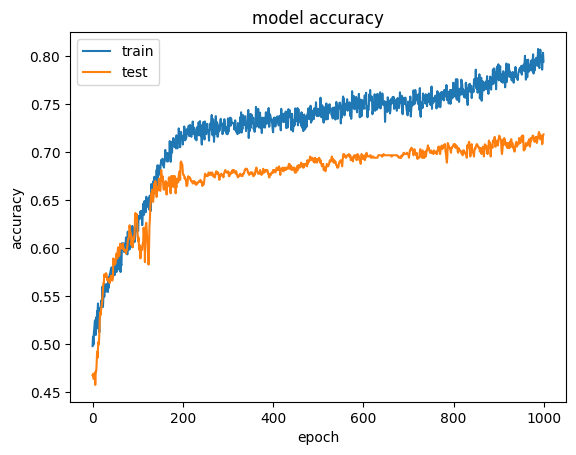

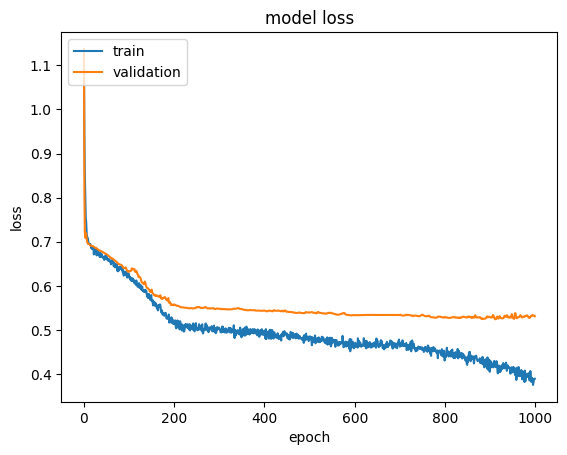

In [ ]:
# list all data in history_simple
print(history_simple.history.keys())
# summarize history_simple for accuracy
plt.plot(history_simple.history['acc'])
plt.plot(history_simple.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history_simple for loss
plt.plot(history_simple.history['loss'])
plt.plot(history_simple.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# Save model because it has a balanced performance
model_simple.save("/content/drive/MyDrive/models/base_model_noLST.keras")

# Save history of base model
with open('/content/drive/MyDrive/models/base_model_history_noLST', 'wb') as file_pi:
    pickle.dump(history_simple.history, file_pi)

Next I'll continue the training of the simple model but with a different learning schedule.

In [ ]:
model_simple_c = Sequential()

# 1st Conv Layer
model_simple_c.add(Conv2D(32, (2, 2), padding = "same", strides = (1, 1), input_shape = (20, 20, 13)))
model_simple_c.add(BatchNormalization())
model_simple_c.add(Activation("relu"))
model_simple_c.add(Dropout(0.2))

# 2nd Conv layer
model_simple_c.add(Conv2D(64, (4, 4), padding = "same", strides = (1, 1)))
model_simple_c.add(BatchNormalization())
model_simple_c.add(Activation("relu"))
model_simple_c.add(Dropout(0.5))

# 3rd Conv layer
model_simple_c.add(Conv2D(128, (2, 2), padding = "same", strides = (2, 2)))
model_simple_c.add(BatchNormalization())
model_simple_c.add(Activation("relu"))
model_simple_c.add(Dropout(0.5))
model_simple_c.add(MaxPool2D(2, 2))

# Dense layer
model_simple_c.add(Flatten())
model_simple_c.add(Dense(256))
model_simple_c.add(Activation("relu"))
model_simple_c.add(Dropout(0.6))
model_simple_c.add(Dense(512))
model_simple_c.add(Activation("relu"))
model_simple_c.add(Dropout(0.3))
model_simple_c.add(Dense(1))
model_simple_c.add(Activation("sigmoid"))

model_simple_c.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 20, 20, 32)        1696      
                                                                 
 batch_normalization_3 (Batc  (None, 20, 20, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 20, 20, 32)        0         
                                                                 
 dropout_5 (Dropout)         (None, 20, 20, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 20, 20, 64)        32832     
                                                                 
 batch_normalization_4 (Batc  (None, 20, 20, 64)       256       
 hNormalization)                                      

In [ ]:
# Load base model
base_model = load_model("/content/drive/MyDrive/models/base_model_noLST.keras")

# Set weights from base model
model_simple_c.set_weights(base_model.get_weights())

In [ ]:
def scheduler(epoch, lr):
    l = 0.000001
    if epoch > 200:
        l = 0.00005

    return l

In [ ]:
callback = LearningRateScheduler(scheduler, verbose = 1)

In [ ]:
optim_simple_c = optimizers.Adam()

In [ ]:
model_simple_c.compile(optimizer = optim_simple_c,
                     loss = "binary_crossentropy",
                     metrics = ["acc"])

In [ ]:
history_simple_c = model_simple_c.fit(X_train,
                                  y_train,
                                  validation_data = (X_val, y_val),
                                  callbacks = [callback],
                                  epochs = 300,
                                  batch_size = 256)


Epoch 1: LearningRateScheduler setting learning rate to 1e-06.
Epoch 1/300
10/10 [==============================] - 4s 70ms/step - loss: 0.3897 - acc: 0.7965 - val_loss: 0.5306 - val_acc: 0.7199 - lr: 1.0000e-06

Epoch 2: LearningRateScheduler setting learning rate to 1e-06.
Epoch 2/300
10/10 [==============================] - 0s 12ms/step - loss: 0.3877 - acc: 0.8053 - val_loss: 0.5303 - val_acc: 0.7174 - lr: 1.0000e-06

Epoch 3: LearningRateScheduler setting learning rate to 1e-06.
Epoch 3/300
10/10 [==============================] - 0s 12ms/step - loss: 0.3841 - acc: 0.7989 - val_loss: 0.5300 - val_acc: 0.7187 - lr: 1.0000e-06

Epoch 4: LearningRateScheduler setting learning rate to 1e-06.
Epoch 4/300
10/10 [==============================] - 0s 12ms/step - loss: 0.3944 - acc: 0.7917 - val_loss: 0.5297 - val_acc: 0.7187 - lr: 1.0000e-06

Epoch 5: LearningRateScheduler setting learning rate to 1e-06.
Epoch 5/300
10/10 [==============================] - 0s 13ms/step - loss: 0.4020 - a

The red line in the following plots represents the performance of the model after implementing the new learning schedule.

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])


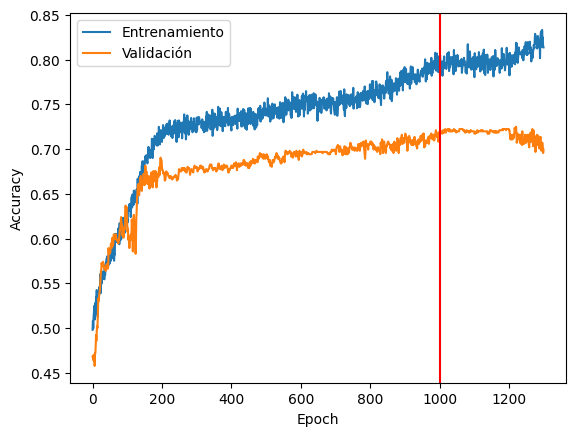

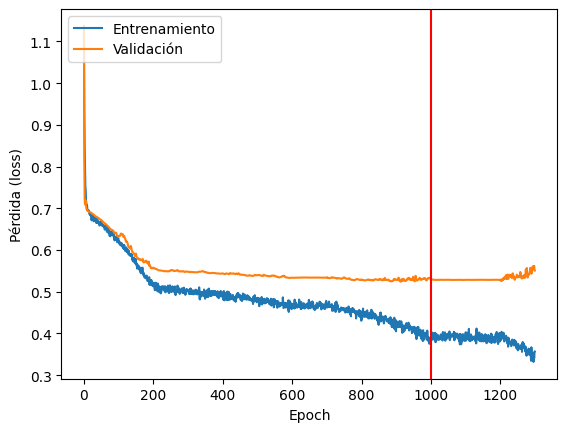

In [ ]:
# Load history from base model
with open("/content/drive/MyDrive/models/base_model_history_noLST", "rb") as file_pi:
    base_model_history = pickle.load(file_pi)

# Append data from fine tuning history
for key in base_model_history.keys():
    for i in range(0, len(history_simple_c.history[key])):
        value = history_simple_c.history[key][i]
        base_model_history[key].append(value)

# list all data in history_simple_c
print(base_model_history.keys())

# summarize base_model for accuracy
plt.plot(base_model_history['acc'])
plt.plot(base_model_history['val_acc'])
plt.axvline(x = 1000, color = "r")
#plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')
plt.show()
# summarize base_model for loss
plt.plot(base_model_history['loss'])
plt.plot(base_model_history['val_loss'])
plt.axvline(x = 1000, color = "r")
#plt.title('model loss')
plt.ylabel('Pérdida (loss)')
plt.xlabel('Epoch')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')
plt.show()

In [ ]:
model_simple_c.evaluate(X_test, y_test)

20/20 [==============================] - 0s 6ms/step - loss: 0.4886 - acc: 0.7444


[0.4885512888431549, 0.7444089651107788]

In [ ]:
# See predictions by class
model_simple_c_pred = model_simple_c.predict(X_test, batch_size = 64)

print(classification_report(y_test, np.where(model_simple_c_pred > 0.5, 1, 0)))

10/10 [==============================] - 0s 9ms/step
              precision    recall  f1-score   support

           0       0.77      0.72      0.75       323
           1       0.72      0.77      0.74       303

    accuracy                           0.74       626
   macro avg       0.74      0.75      0.74       626
weighted avg       0.75      0.74      0.74       626



In [ ]:
# Save model with 74% accuracy
model_simple_c.save("/content/drive/MyDrive/models/model_noLST_74acc.keras")

# Save history of model with 74% accuracy
with open('/content/drive/MyDrive/models/model_noLST_74acc_history', 'wb') as file_pi:
    pickle.dump(base_model_history, file_pi)